# Machine Learning Engineer Nanodegree: Forecasting COVID-19 Cases – A DeepAR Model

### Domain Background
On December 31, 2019, the World Health Organization (WHO) was informed of an outbreak of “pneumonia of unknown cause” detected in Wuhan City, Hubei Province, China. Identified as coronavirus disease 2019, it quickly came to be known as COVID-19 and has resulted in an ongoing global pandemic. As of 20 June 2020, more than 8.74 million cases have been reported across 188 countries and territories, resulting in more than 462,000 deaths. More
than 4.31 million people have recovered.[^1]

In response to this ongoing public health emergency, Johns Hopkins University (JHU), a private research university in Maryland, USA, developed an interactive web-based dashboard hosted by their Center for Systems Science and Engineering (CSSE). The dashboard visualizes and tracks reported cases in real-time, illustrating the location and number of confirmed COVID-19 cases, deaths and recoveries for all affected countries. It is used by researchers, public health authorities, news
agencies and the general public. All the data collected and displayed is made freely available in a [GitHub repository](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data).

### Problem Statement
This project seeks to forecast number of people infected and number of deaths caused by COVID-19 for a time duration of 14-days based on
historical data from JHU. I will be using Amazon SageMaker DeepAR forecasting algorithm, a supervised learning algorithm for forecasting
scalar (one-dimensional) time series using recurrent neural networks (RNN) to produce both point and probabilistic forecasts[^2].
DeepAR is an underutilized approach in this area.[^3] The dataset contains hundreds of related time series, and DeepAR outperforms classical
forecasting methods including but not limited to autoregressive integrated moving average (ARIMA), exponential smoothing (ETS), Time Series
Forecasting with Linear Learner for this type of applications. I will be using [DeepAR](https://github.com/sahussain/ML_SageMaker_Studies/blob/master/Time_Series_Forecasting/Energy_Consumption_Solution.ipynb) and [Time Series Forecasting with Linear Learner](https://github.com/awslabs/amazon-sagemaker-examples/blob/80333fd4632cf6d924d0b91c33bf80da3bdcf926/introduction_to_applying_machine_learning/linear_time_series_forecast/linear_time_series_forecast.ipynb)

-----------
[^1]:[COVID-19 Dashboard](https://systems.jhu.edu/research/public-health/ncov/) by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University (JHU)". ArcGIS. Johns Hopkins University. Retrieved 20 June 2020.

[^2]:[DeepAR Forecasting Algorithm. Amazon Web Services](https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html). Retrieved 20 June, 2020 

[^3]:[Time series prediction](https://www.telesens.co/2019/06/08/time-series-prediction/). Telesens. Retrieved 20 June, 2020.

### Loading in the resources. 

In [1]:
#General
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
import json # import json for formatting data
import os # os for saving
import io

# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

# for both DeepAR & Linear Learner
from sagemaker.amazon.amazon_estimator import get_image_uri
import sagemaker
from sagemaker.estimator import Estimator

#for Linear Learner
import sagemaker.amazon.common as smac
from sagemaker.predictor import csv_serializer, json_deserializer

### Initialize Global variables

In [2]:
sagemaker_session = sagemaker.Session()
role = get_execution_role()
bucket = sagemaker_session.default_bucket()
prefix_DeepAR='deepar'
prefix = 'linear'


container_linear_learner = get_image_uri(boto3.Session().region_name,'linear-learner')
container_DeepAR = get_image_uri(boto3.Session().region_name,'forecasting-deepar')


### Clean-up functions

In [3]:
#convenience function to delete prediction endpoints after we're done with them
def delete_endpoint(predictor):
        try:
            boto3.client('sagemaker').delete_endpoint(EndpointName=predictor.endpoint)
            print('Deleted {}'.format(predictor.endpoint))
        except:
            print('Already deleted: {}'.format(predictor.endpoint))

## Load and Explore the Data

In [4]:
! wget -N https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv

--2020-06-22 01:03:08--  https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.64.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.64.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1556077 (1.5M) [text/plain]
Saving to: ‘time_series_covid19_confirmed_US.csv’

time_series_covid19 100%[===================>]   1.48M  --.-KB/s    in 0.03s   

Last-modified header missing -- time-stamps turned off.
2020-06-22 01:03:08 (50.2 MB/s) - ‘time_series_covid19_confirmed_US.csv’ saved [1556077/1556077]



In [5]:
csv_file = 'time_series_covid19_confirmed_US.csv'
covid_df = pd.read_csv(csv_file)

# print out the first few rows of data info
covid_df.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,...,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,...,183,183,183,183,185,186,188,192,200,222
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.0979,145.6739,...,30,30,30,30,30,30,30,30,30,30
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.2208,-66.5901,...,5352,5536,5690,5811,5890,5951,6003,6111,6195,6463
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.3358,-64.8963,...,72,72,72,72,72,72,73,73,73,73


In [6]:
#Geting colunm names
list(covid_df.columns) 

['UID',
 'iso2',
 'iso3',
 'code3',
 'FIPS',
 'Admin2',
 'Province_State',
 'Country_Region',
 'Lat',
 'Long_',
 'Combined_Key',
 '1/22/20',
 '1/23/20',
 '1/24/20',
 '1/25/20',
 '1/26/20',
 '1/27/20',
 '1/28/20',
 '1/29/20',
 '1/30/20',
 '1/31/20',
 '2/1/20',
 '2/2/20',
 '2/3/20',
 '2/4/20',
 '2/5/20',
 '2/6/20',
 '2/7/20',
 '2/8/20',
 '2/9/20',
 '2/10/20',
 '2/11/20',
 '2/12/20',
 '2/13/20',
 '2/14/20',
 '2/15/20',
 '2/16/20',
 '2/17/20',
 '2/18/20',
 '2/19/20',
 '2/20/20',
 '2/21/20',
 '2/22/20',
 '2/23/20',
 '2/24/20',
 '2/25/20',
 '2/26/20',
 '2/27/20',
 '2/28/20',
 '2/29/20',
 '3/1/20',
 '3/2/20',
 '3/3/20',
 '3/4/20',
 '3/5/20',
 '3/6/20',
 '3/7/20',
 '3/8/20',
 '3/9/20',
 '3/10/20',
 '3/11/20',
 '3/12/20',
 '3/13/20',
 '3/14/20',
 '3/15/20',
 '3/16/20',
 '3/17/20',
 '3/18/20',
 '3/19/20',
 '3/20/20',
 '3/21/20',
 '3/22/20',
 '3/23/20',
 '3/24/20',
 '3/25/20',
 '3/26/20',
 '3/27/20',
 '3/28/20',
 '3/29/20',
 '3/30/20',
 '3/31/20',
 '4/1/20',
 '4/2/20',
 '4/3/20',
 '4/4/20',
 '4/5

### Datasets and Inputs
The datasets are accessed from files provided by the JHU GitHub
repository [time_series_covid19_confirmed_US.csv](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv)

The file have the same columns:
* UID - UID = 840 (country code3) + 000XX (state FIPS code). Ranging from
8400001 to 84000056.
* iso2- Officially assigned country code identifiers 2 Chr (US, CA, ...)
* iso3 - Officially assigned country code identifiers 3 Chr.(USA, CAN,
...)
* code3- country code USA = 840
* FIPS -Federal Information Processing Standards code that uniquely
identifies counties within the USA.
* admin2 - County name. US only.
* Province_State - The name of the State within the USA.
* Country_Region - The name of the Country (US).
* Combined_Key - Province_State + Country_Region
* Population - Population
* Number of cases are is columns where each column is a day

Frist thing we need to do is to filter code3- country code USA = 840 as the scope of this project is limited to US excluding territories

In [7]:
covid_df = covid_df[covid_df.code3 == 840]

In [8]:
covid_df.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20
5,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,312,323,331,357,364,367,369,394,405,425
6,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,343,353,361,364,368,374,377,386,398,405
7,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,214,221,226,234,237,244,250,262,265,271
8,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,93,97,100,104,108,113,115,118,123,123
9,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,87,95,102,110,114,119,121,127,136,140


In [9]:
#pivot the dates into a date and cases column
meta_data = ['UID',
 'iso2',
 'iso3',
 'code3',
 'FIPS',
 'Admin2',
 'Province_State',
 'Country_Region',
 'Lat',
 'Long_',
 'Combined_Key']

covid_df = covid_df.melt(id_vars=meta_data, var_name='Date', value_name='Cases')

In [10]:
# we only need the 'Combined_Key','Date','Case'
keep_columns = ['Combined_Key','Date','Cases']

covid_df = covid_df.filter(items=keep_columns)

In [11]:
covid_df.head()

,Combined_Key,Date,Cases
0,"Autauga, Alabama, US",1/22/20,0
1,"Baldwin, Alabama, US",1/22/20,0
2,"Barbour, Alabama, US",1/22/20,0
3,"Bibb, Alabama, US",1/22/20,0
4,"Blount, Alabama, US",1/22/20,0


In [12]:
#need to fix date format
covid_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491656 entries, 0 to 491655
Data columns (total 3 columns):
Combined_Key    491656 non-null object
Date            491656 non-null object
Cases           491656 non-null int64
dtypes: int64(1), object(2)
memory usage: 11.3+ MB


`Date 491656 non-null object` need to change

In [13]:
covid_df['Date']= pd.to_datetime(covid_df['Date'])

In [14]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491656 entries, 0 to 491655
Data columns (total 3 columns):
Combined_Key    491656 non-null object
Date            491656 non-null datetime64[ns]
Cases           491656 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 11.3+ MB


`Date 491656 non-null datetime64[ns]` This is good

In [15]:
covid_df.head()

,Combined_Key,Date,Cases
0,"Autauga, Alabama, US",2020-01-22,0
1,"Baldwin, Alabama, US",2020-01-22,0
2,"Barbour, Alabama, US",2020-01-22,0
3,"Bibb, Alabama, US",2020-01-22,0
4,"Blount, Alabama, US",2020-01-22,0


In [16]:
# adding a Updated time column
covid_df['Time'] = '23:59'

In [17]:
covid_df.head()

,Combined_Key,Date,Cases,Time
0,"Autauga, Alabama, US",2020-01-22,0,23:59
1,"Baldwin, Alabama, US",2020-01-22,0,23:59
2,"Barbour, Alabama, US",2020-01-22,0,23:59
3,"Bibb, Alabama, US",2020-01-22,0,23:59
4,"Blount, Alabama, US",2020-01-22,0,23:59


In [18]:
covid_df.Time = pd.to_timedelta(covid_df.Time + ':00', unit='h') #converting string time to time

In [19]:
covid_df.head()

,Combined_Key,Date,Cases,Time
0,"Autauga, Alabama, US",2020-01-22,0,23:59:00
1,"Baldwin, Alabama, US",2020-01-22,0,23:59:00
2,"Barbour, Alabama, US",2020-01-22,0,23:59:00
3,"Bibb, Alabama, US",2020-01-22,0,23:59:00
4,"Blount, Alabama, US",2020-01-22,0,23:59:00


make date & Time as one field

In [20]:
covid_df.index = covid_df.Date + covid_df.Time 

In [21]:
covid_df.head()

,Combined_Key,Date,Cases,Time
2020-01-22 23:59:00,"Autauga, Alabama, US",2020-01-22,0,23:59:00
2020-01-22 23:59:00,"Baldwin, Alabama, US",2020-01-22,0,23:59:00
2020-01-22 23:59:00,"Barbour, Alabama, US",2020-01-22,0,23:59:00
2020-01-22 23:59:00,"Bibb, Alabama, US",2020-01-22,0,23:59:00
2020-01-22 23:59:00,"Blount, Alabama, US",2020-01-22,0,23:59:00


In [22]:
covid_df.index.name = 'Date-Time' #changing index to datetime

In [23]:
covid_df.head()

,Combined_Key,Date,Cases,Time
Date-Time,,,,
2020-01-22 23:59:00,"Autauga, Alabama, US",2020-01-22,0,23:59:00
2020-01-22 23:59:00,"Baldwin, Alabama, US",2020-01-22,0,23:59:00
2020-01-22 23:59:00,"Barbour, Alabama, US",2020-01-22,0,23:59:00
2020-01-22 23:59:00,"Bibb, Alabama, US",2020-01-22,0,23:59:00
2020-01-22 23:59:00,"Blount, Alabama, US",2020-01-22,0,23:59:00


In [24]:
#Drop date and time column
covid_df = covid_df.drop('Time', axis=1)
covid_df = covid_df.drop('Date', axis=1)

In [25]:
covid_df.head()

,Combined_Key,Cases
Date-Time,,
2020-01-22 23:59:00,"Autauga, Alabama, US",0
2020-01-22 23:59:00,"Baldwin, Alabama, US",0
2020-01-22 23:59:00,"Barbour, Alabama, US",0
2020-01-22 23:59:00,"Bibb, Alabama, US",0
2020-01-22 23:59:00,"Blount, Alabama, US",0


In [26]:
covid_df.describe()

,Cases
count,491656.000000
mean,216.096962
std,2689.729885
min,0.000000
25%,0.000000
50%,1.000000
75%,26.000000
max,212061.000000


In [27]:
print(covid_df.shape)

(491656, 2)


In [28]:
#lets Get # of unique cities list
Combined_Keylist = covid_df.filter(items=['Combined_Key'])['Combined_Key'].unique()

In [29]:
print(Combined_Keylist.shape)

(3256,)


Due to the limited amount of money we have for this project I will only train and test for 3 cities

I know that DeepAr can take cat as categorical Data.

lets take a look at the data, becasue there is lots of data we will only look at 3 cities
- city1 = "Los Angeles, California, US"
- city2 = "Unassigned, Rhode Island, US"
- city3 = "New York City, New York, US"

In [30]:
city1 = "Los Angeles, California, US"
city2 = "Unassigned, Rhode Island, US"
city3 = "New York City, New York, US"

In [86]:
def getCasesforCity(df, city):
    Cases_City = (df[df.Combined_Key == city]).filter(items=['Date','Cases'])
    returnCases = Cases_City['Cases'].copy()
    return returnCases

def getCasesforCityAsTS(df, city, ferq='D'):
    city_df = getCasesforCity(df, city)
    city_df = city_df.resample(freq).sum()
    period = len(city_df)
    data = city_df[0:period]
    index = pd.date_range(start='2020-01-22', periods=period, freq='D')
    time_series = pd.Series(data=data, index=index)
    return time_series

def plotCases(df, city):
       
    # Create figure and plot space
    plt.figure(figsize=(15,8))
    df.plot(title="# of Cases for " + city, color='blue') 
    plt.show()

In [71]:
covid_df_city2 = getCasesforCity(covid_df, city2)



In [82]:
len(covid_df_city2)

151

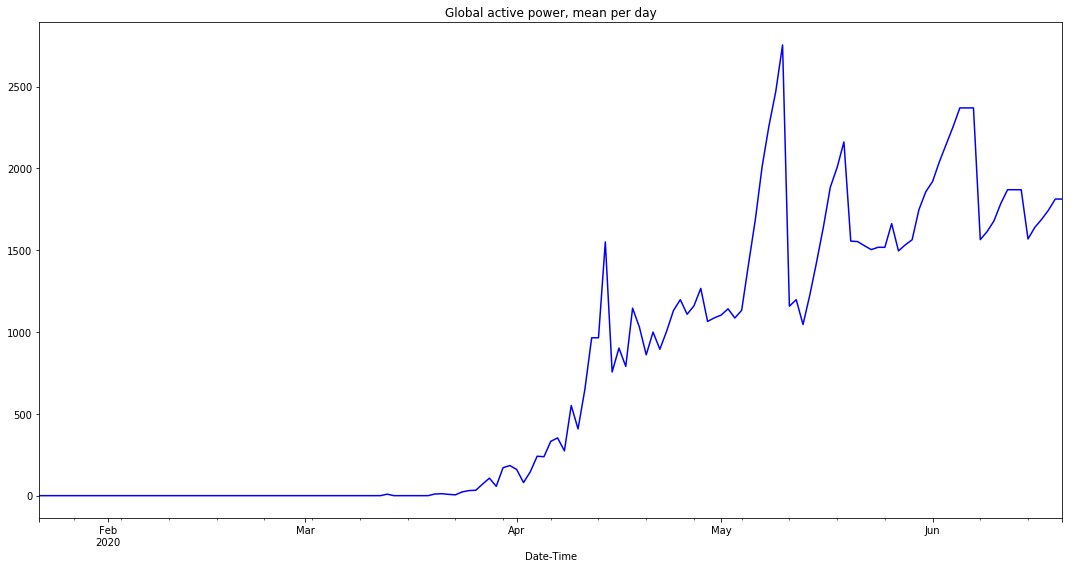

In [75]:
# resample over day (D)
freq = 'D'
# calculate the mean active power for a day
covid_city_df = covid_df_city2.resample(freq).sum()

# display the mean values
plt.figure(figsize=(15,8))
covid_city_df.plot(title='Global active power, mean per day', color='blue') 
plt.tight_layout()
plt.show()

In [76]:
covid_city_df.head()

Date-Time
2020-01-22    0
2020-01-23    0
2020-01-24    0
2020-01-25    0
2020-01-26    0
Freq: D, Name: Cases, dtype: int64

In [80]:

data = covid_city_df[0:151]
index = pd.date_range(start='2020-01-22', periods=151, freq='D')
time_series = pd.Series(data=data, index=index)


In [81]:
print(time_series)

2020-01-22       0
2020-01-23       0
2020-01-24       0
2020-01-25       0
2020-01-26       0
2020-01-27       0
2020-01-28       0
2020-01-29       0
2020-01-30       0
2020-01-31       0
2020-02-01       0
2020-02-02       0
2020-02-03       0
2020-02-04       0
2020-02-05       0
2020-02-06       0
2020-02-07       0
2020-02-08       0
2020-02-09       0
2020-02-10       0
2020-02-11       0
2020-02-12       0
2020-02-13       0
2020-02-14       0
2020-02-15       0
2020-02-16       0
2020-02-17       0
2020-02-18       0
2020-02-19       0
2020-02-20       0
              ... 
2020-05-22    1528
2020-05-23    1504
2020-05-24    1518
2020-05-25    1518
2020-05-26    1663
2020-05-27    1496
2020-05-28    1533
2020-05-29    1564
2020-05-30    1748
2020-05-31    1857
2020-06-01    1920
2020-06-02    2041
2020-06-03    2148
2020-06-04    2254
2020-06-05    2370
2020-06-06    2370
2020-06-07    2370
2020-06-08    1565
2020-06-09    1614
2020-06-10    1679
2020-06-11    1785
2020-06-12  

In [95]:
time_series = getCasesforCityAsTS(covid_df, city2)

In [93]:
# create truncated, training time series
def create_training_series(complete_time_series, prediction_length):
    '''Given a complete list of time series data, create training time series.
       :param complete_time_series: A list of all complete time series.
       :param prediction_length: The number of points we want to predict.
       :return: A list of training time series.
       '''
    # get training series
    time_series_training = []
    time_series_training=complete_time_series[:-prediction_length]
        
    return time_series_training

In [96]:
# test your code!

# set prediction length
prediction_length = 14 # 30 days ~ a month

time_series_training = create_training_series(time_series, prediction_length)

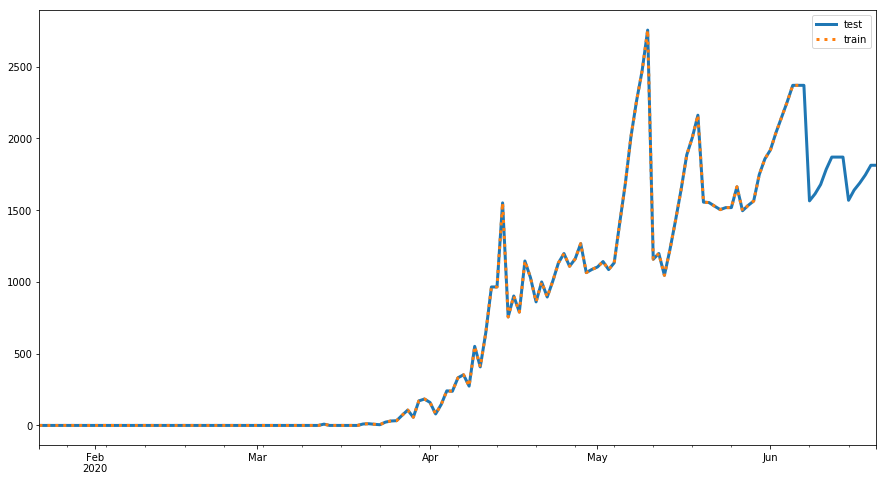

In [97]:
# display train/test time series

plt.figure(figsize=(15,8))
# test data is the whole time series
time_series.plot(label='test', lw=3)
# train data is all but the last prediction pts
time_series_training.plot(label='train', ls=':', lw=3)

plt.legend()
plt.show()

## Convert to JSON
According to the DeepAR documentation, DeepAR expects to see input training data in a JSON format, with the following fields:

start: A string that defines the starting date of the time series, with the format 'YYYY-MM-DD HH:MM:SS'.
target: An array of numerical values that represent the time series.
cat (optional): A numerical array of categorical features that can be used to encode the groups that the record belongs to. This is useful for finding models per class of item, such as in retail sales, where you might have {'shoes', 'jackets', 'pants'} encoded as categories {0, 1, 2}.
The input data should be formatted with one time series per line in a JSON file. Each line looks a bit like a dictionary, for example:

`{"start":'2007-01-01 00:00:00', "target": [2.54, 6.3, ...], "cat": [1]}

`{"start": "2012-01-30 00:00:00", "target": [1.0, -5.0, ...], "cat": [0]} 

In [98]:
def series_to_json_obj(ts):
    '''Returns a dictionary of values in DeepAR, JSON format.
       :param ts: A single time series.
       :return: A dictionary of values with "start" and "target" keys.
       '''
    # get start time and target from the time series, ts
    json_obj = {"start": str(ts.index[0]), "target": list(ts)}
    return json_obj

In [99]:
# test out the code
ts = time_series

json_obj = series_to_json_obj(ts)

print(json_obj)

{'start': '2020-01-22 00:00:00', 'target': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 10, 12, 8, 5, 23, 31, 33, 71, 107, 57, 171, 184, 160, 80, 146, 241, 238, 332, 353, 274, 551, 408, 649, 965, 965, 1551, 756, 902, 790, 1146, 1030, 861, 1000, 895, 1006, 1132, 1198, 1109, 1160, 1267, 1065, 1087, 1104, 1142, 1086, 1133, 1414, 1686, 2011, 2260, 2470, 2755, 1158, 1198, 1046, 1227, 1430, 1645, 1885, 2006, 2162, 1556, 1553, 1528, 1504, 1518, 1518, 1663, 1496, 1533, 1564, 1748, 1857, 1920, 2041, 2148, 2254, 2370, 2370, 2370, 1565, 1614, 1679, 1785, 1870, 1870, 1870, 1569, 1640, 1689, 1745, 1813, 1813]}


In [104]:
# import json for formatting data
import json
import os # and os for saving

def write_json_dataset(time_series, filename): 
    with open(filename, 'wb') as f:
        json_line = json.dumps(series_to_json_obj(ts)) + '\n'
        json_line = json_line.encode('utf-8')
        f.write(json_line)
    print(filename + ' saved.')

In [101]:
# save this data to a local directory
data_dir = 'json_energy_data'

# make data dir, if it does not exist
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [106]:

# directories to save train/test data
train_key = os.path.join(data_dir, 'train.json')
test_key = os.path.join(data_dir, 'test.json')

# write train/test JSON files
write_json_dataset(time_series_training, train_key)        
write_json_dataset(time_series, test_key)       


json_energy_data/train.json saved.
json_energy_data/test.json saved.


### Sagemaker resources

Let's start by specifying:

-   The sagemaker role and session for training a model.
-   A default S3 bucket where we can save our training, test, and model data.

In [107]:
# general prefix
prefix='covid-19-city'

# *unique* train/test prefixes
train_prefix   = '{}/{}'.format(prefix, 'train')
test_prefix    = '{}/{}'.format(prefix, 'test')

# uploading data to S3, and saving locations
train_path  = sagemaker_session.upload_data(train_key, bucket=bucket, key_prefix=train_prefix)
test_path   = sagemaker_session.upload_data(test_key,  bucket=bucket, key_prefix=test_prefix)

In [108]:
print('Training data is stored in: '+ train_path)
print('Test data is stored in: '+ test_path)

Training data is stored in: s3://sagemaker-us-east-1-580635780882/covid-19-city/train/train.json
Test data is stored in: s3://sagemaker-us-east-1-580635780882/covid-19-city/test/test.json


In [110]:
# dir to save model artifacts
s3_output_path = "s3://{}/{}/output".format(bucket, prefix)

# instantiate a DeepAR estimator
estimator = Estimator(sagemaker_session=sagemaker_session,
                      image_name=container_DeepAR,
                      role=role,
                      train_instance_count=1,
                      train_instance_type='ml.c4.xlarge',
                      output_path=s3_output_path
                      )

In [111]:
freq='D'
context_length=30 # same as prediction_length

hyperparameters = {
    "epochs": "50",
    "time_freq": freq,
    "prediction_length": str(prediction_length),
    "context_length": str(context_length),
    "num_cells": "50",
    "num_layers": "2",
    "mini_batch_size": "128",
    "learning_rate": "0.001",
    "early_stopping_patience": "10"
}

In [112]:
# set the hyperparams
estimator.set_hyperparameters(**hyperparameters)


In [113]:
%%time
# train and test channels
data_channels = {
    "train": train_path,
    "test": test_path
}

# fit the estimator
estimator.fit(inputs=data_channels)

2020-06-22 03:12:12 Starting - Starting the training job...
2020-06-22 03:12:14 Starting - Launching requested ML instances.........
2020-06-22 03:13:57 Starting - Preparing the instances for training......
2020-06-22 03:14:45 Downloading - Downloading input data...
2020-06-22 03:15:32 Training - Downloading the training image..Arguments: train
[06/22/2020 03:15:54 INFO 140377014056768] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'num_dynamic_feat': u'auto', u'dropout_rate': u'0.10', u'mini_batch_size': u'128', u'test_quantiles': u'[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'num_eval_samples': u'100', u'learning_rate': u'0.001', u'num_cells': u'40', u'num_layers': u'2', u'embedding_dimension': u'10', u'_kvstore': u'auto', u'_num_kv_servers': u'auto', u'cardinality': u'auto', u'likelihood': u'student-t', u'early_stopping_patience': u''}
[06/22/2020 03:1

UnexpectedStatusException: Error for Training job forecasting-deepar-2020-06-22-03-12-12-277: Failed. Reason: ClientError: Very low number of time observations (found 151 observations in 1 time series). DeepAR requires at least 300 observations.